In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import gc
import os
import sys

## functions

In [2]:
def save_dataframe(path, dataframe):
    np.save(path + ".data", dataframe.values)
    np.save(path + ".header", dataframe.columns)
    
def load_dataframe(path):
    data = np.load(path + ".data.npy")
    header = np.load(path + ".header.npy")
    return pd.DataFrame(data=data, columns=header)

def save_dataframe32(path, dataframe, keep=[]):
    col64 = [col_ for col_ in dataframe.columns if col_ in keep]
    col32 = [col_ for col_ in dataframe.columns if col_ not in keep]
    dataframe64 = dataframe[col64]
    dataframe32 = dataframe[col32]
    np.save(path + ".data64", dataframe64.values)
    np.save(path + ".header64", col64)
    np.save(path + ".data32", dataframe32.values.astype(np.float32))
    np.save(path + ".header32", col32)

def load_dataframe32(path):
    path_data32 = path + ".data32.npy"
    path_header32 = path + ".header32.npy"
    path_data64 = path + ".data64.npy"
    path_header64 = path + ".header64.npy"
    result = pd.DataFrame()
    if os.path.exists(path_data32):
        data32 = np.load(path_data32)
        header32 = np.load(path_header32)
        df32 = pd.DataFrame(data=data32, columns=header32)
        result = pd.concat([result, df32], axis=1)
    if os.path.exists(path_data64):
        data64 = np.load(path_data64)
        header64 = np.load(path_header64)
        df64 = pd.DataFrame(data=data64, columns=header64)
        result = pd.concat([result, df64], axis=1)
    return result

In [3]:
import xgboost as xgb

class XgbWrapper:
    def __init__(self, seed=0, params=None):
        self.param = params
        self.param['seed'] = seed
        self.nrounds = params.pop('nrounds', 250)

    def train(self, x_train, y_train):
        dtrain = xgb.DMatrix(x_train, label=y_train)
        self.gbdt = xgb.train(self.param, dtrain, self.nrounds)

    def predict(self, x):
        return self.gbdt.predict(xgb.DMatrix(x))

In [4]:
class SklearnWrapper:
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict_proba(x)[:,1]

class CatboostWrapper:
    def __init__(self, clf, seed=0, params=None):
        params['random_seed'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict_proba(x)[:,1]
        
class LightGBMWrapper:
    def __init__(self, clf, seed=0, params=None):
        params['feature_fraction_seed'] = seed
        params['bagging_seed'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict_proba(x)[:,1]

## load data

In [6]:
data = load_dataframe32("./bindata/data_013")
data["SK_ID_CURR"] = data.SK_ID_CURR.astype("int")

test = load_dataframe32("./bindata/test_013")
test["SK_ID_CURR"] = test.SK_ID_CURR.astype("int")

y = load_dataframe32("./bindata/y_013")
y["SK_ID_CURR"] = y.SK_ID_CURR.astype("int")

In [7]:
data_train = data[data.SK_ID_CURR < 130000]
data_val = data[(data.SK_ID_CURR >= 130000) & (data.SK_ID_CURR < 150000)]

ydata_train = y[y.SK_ID_CURR < 130000]
ydata_val = y[(y.SK_ID_CURR >= 130000) & (y.SK_ID_CURR < 150000)]

In [8]:
for source_name in (
    "buro_wide_013",
    "buro_full_wide_013",
    "pos_bal_wide_013",
    "cc_bal_wide_013",
    "buro_bal_timestep1_013",
    "buro_bal_timestep2_013",
    "pos_bal_timestep1_013",
    "pos_bal_timestep2_013",
    "cc_bal_timestep1_013",
    "cc_bal_timestep2_013"
):
    target_name = "./bindata/" + source_name + "_nmf5"
    nmf_data = load_dataframe32(target_name)
    nmf_data["SK_ID_CURR"] = nmf_data.SK_ID_CURR.astype("int")
    nmf_data.columns = ["{}_{}".format(source_name, col_) if col_ != "SK_ID_CURR" else col_ for col_ in nmf_data.columns]
    data_train = data_train.merge(right=nmf_data, how="left", on="SK_ID_CURR")
    data_val = data_val.merge(right=nmf_data, how="left", on="SK_ID_CURR")
    del nmf_data
    gc.collect()

In [9]:
buro_wide = load_dataframe32("./bindata/buro_wide_013")
buro_full_wide = load_dataframe32("./bindata/buro_full_wide_013")
pos_bal_wide = load_dataframe32("./bindata/pos_bal_wide_013")
cc_bal_wide = load_dataframe32("./bindata/cc_bal_wide_013")

buro_wide["SK_ID_CURR"] = buro_wide.SK_ID_CURR.astype("int")
buro_full_wide["SK_ID_CURR"] = buro_full_wide.SK_ID_CURR.astype("int")
pos_bal_wide["SK_ID_CURR"] = pos_bal_wide.SK_ID_CURR.astype("int")
cc_bal_wide["SK_ID_CURR"] = cc_bal_wide.SK_ID_CURR.astype("int")

for wi, data_ in enumerate((buro_wide, buro_full_wide, pos_bal_wide, cc_bal_wide)):
    # data_.columns = ["w{}_{}".format(wi, col_) for col_ in data_.columns]
    data_train = data_train.merge(right=data_, how="left", on="SK_ID_CURR")
    data_val = data_val.merge(right=data_, how="left", on="SK_ID_CURR")
    del data_
    gc.collect()

In [10]:
for name in (
    "./bindata/bureau_and_balance_015",
    "./bindata/previous_applications_015",
    "./bindata/pos_cash_015",
    "./bindata/installments_payments_015",
    "./bindata/credit_card_balance_015",
):
    data_ = load_dataframe32(name)
    data_["SK_ID_CURR"] = data_.SK_ID_CURR.astype("int")
    data_train = data_train.merge(right=data_, how="left", on="SK_ID_CURR")
    data_val = data_val.merge(right=data_, how="left", on="SK_ID_CURR")
    del data_
    gc.collect()

In [11]:
features = [col_ for col_ in data_train.columns if not col_.startswith("SK_ID")]
print(len(features))

2026


In [12]:
len(set(features))

2026

In [13]:
vc_train = data_train.nunique()
vc_train[vc_train > 1]

SK_ID_CURR                                    25803
NAME_CONTRACT_TYPE                                2
CODE_GENDER                                       2
FLAG_OWN_CAR                                      2
FLAG_OWN_REALTY                                   2
CNT_CHILDREN                                     10
AMT_INCOME_TOTAL                                557
AMT_CREDIT_x                                   2722
AMT_ANNUITY_x                                  6835
AMT_GOODS_PRICE_x                               437
NAME_TYPE_SUITE                                   8
NAME_INCOME_TYPE                                  6
NAME_EDUCATION_TYPE                               5
NAME_FAMILY_STATUS                                5
NAME_HOUSING_TYPE                                 6
REGION_POPULATION_RELATIVE                       80
DAYS_BIRTH                                    12919
DAYS_EMPLOYED                                  6419
DAYS_REGISTRATION                             10729
DAYS_ID_PUBL

In [14]:
features = [col_ for col_ in vc_train[vc_train > 1].index if not col_.startswith("SK_ID")]
print(len(features), len(set(features)))

1889 1889


## train & validate

### xgb

In [41]:
X_num_train = data_train[features].values
X_num_val = data_val[features].values

y_train = ydata_train.TARGET.values
y_val = ydata_val.TARGET.values

xgb_params = {
     "objective": "binary:logistic",
     "booster": "gbtree",
     "eval_metric": "auc",
     "nthread": 8,
     "eta": 0.025,
     "max_depth": 6,
     "min_child_weight": 19,
     "gamma": 0,
     "subsample": 0.8,
     "colsample_bytree": 0.632,
     "alpha": 0,
     "lambda": 0.05,
     "nrounds": 250 # 2000
}

xgb_params = {
    "objective": "binary:logistic",
    "booster": "gbtree",
    "eval_metric": "auc",
    "nthread": 4,
    "eta": 0.025, # 0.05,
    "max_depth": 6,
    "min_child_weight": 22,
    "gamma": 0,
    "subsample": 0.7,
    "colsample_bytree": 0.7,
    "colsample_bylevel": 0.7,
    "alpha": 0,
    "lambda": 0,
    "nrounds": 250 #2000
}

xgb_clf = XgbWrapper(params=xgb_params)
xgb_clf.train(X_num_train, y_train)
pred_val = xgb_clf.predict(X_num_val)
roc_auc_score(y_val, pred_val)

0.76608406730783019

1. 0.76450360090667746

2. 0.76623731737172618 **lb .792 with IDs, param0**

3. 0.76554654483931239 **get rid of IDs, param1 **

4. 0.76608406730783019 **get rid of IDs, param1 **

### lgb

In [15]:
X_num_train = data_train[features].values
X_num_val = data_val[features].values

y_train = ydata_train.TARGET.values
y_val = ydata_val.TARGET.values

lgb_params =  {
    "nthread": 8,
    "n_estimators": 250, # 10000,
    "learning_rate": 0.02,
    "num_leaves": 34,
    "colsample_bytree": 0.9497036,
    "subsample": 0.8715623,
    "subsample_freq": 1,
    "max_depth": 8,
    "reg_alpha": 0.041545473,
    "reg_lambda": 0.0735294,
    "min_split_gain": 0.0222415,
    "min_child_weight": 39.3259775,
    "random_state": 0,
    "silent": -1,
    "verbose": -1
}

lg_clf = LightGBMWrapper(clf=LGBMClassifier, seed=0, params=lgb_params)
lg_clf.train(X_num_train, y_train)
pred_val = lg_clf.predict(X_num_val)
roc_auc_score(y_val, pred_val)

0.76875957348538315

1. 0.76213752306289995
2. 0.76875957348538315 **current best**

1. 0.75816139082616663
2. 0.76239002619826557 rlimp1
3. 0.76486055795697594 rlimp2
4. 0.76319097794387836 imp1

## feature selection

## submission

In [17]:
for source_name in (
    "buro_wide_013",
    "buro_full_wide_013",
    "pos_bal_wide_013",
    "cc_bal_wide_013",
    "buro_bal_timestep1_013",
    "buro_bal_timestep2_013",
    "pos_bal_timestep1_013",
    "pos_bal_timestep2_013",
    "cc_bal_timestep1_013",
    "cc_bal_timestep2_013"
):
    target_name = "./bindata/" + source_name + "_nmf5"
    nmf_data = load_dataframe32(target_name)
    nmf_data["SK_ID_CURR"] = nmf_data.SK_ID_CURR.astype("int")
    nmf_data.columns = ["{}_{}".format(source_name, col_) if col_ != "SK_ID_CURR" else col_ for col_ in nmf_data.columns]
    data = data.merge(right=nmf_data, how="left", on="SK_ID_CURR")
    test = test.merge(right=nmf_data, how="left", on="SK_ID_CURR")
    del nmf_data
    gc.collect()
    
buro_wide = load_dataframe32("./bindata/buro_wide_013")
buro_full_wide = load_dataframe32("./bindata/buro_full_wide_013")
pos_bal_wide = load_dataframe32("./bindata/pos_bal_wide_013")
cc_bal_wide = load_dataframe32("./bindata/cc_bal_wide_013")

buro_wide["SK_ID_CURR"] = buro_wide.SK_ID_CURR.astype("int")
buro_full_wide["SK_ID_CURR"] = buro_full_wide.SK_ID_CURR.astype("int")
pos_bal_wide["SK_ID_CURR"] = pos_bal_wide.SK_ID_CURR.astype("int")
cc_bal_wide["SK_ID_CURR"] = cc_bal_wide.SK_ID_CURR.astype("int")

for wi, data_ in enumerate((buro_wide, buro_full_wide, pos_bal_wide, cc_bal_wide)):
    # data_.columns = ["w{}_{}".format(wi, col_) for col_ in data_.columns]
    data = data.merge(right=data_, how="left", on="SK_ID_CURR")
    test = test.merge(right=data_, how="left", on="SK_ID_CURR")
    del data_
    gc.collect()
    
for name in (
    "./bindata/bureau_and_balance_015",
    "./bindata/previous_applications_015",
    "./bindata/pos_cash_015",
    "./bindata/installments_payments_015",
    "./bindata/credit_card_balance_015",
):
    data_ = load_dataframe32(name)
    data_["SK_ID_CURR"] = data_.SK_ID_CURR.astype("int")
    data = data.merge(right=data_, how="left", on="SK_ID_CURR")
    test = test.merge(right=data_, how="left", on="SK_ID_CURR")
    del data_
    gc.collect()

In [20]:
data.shape, test.shape, y.shape

((307507, 2030), (48744, 2030), (307507, 2))

### xgb

In [42]:
a = time.time()

X_data = data[features].values
X_test = test[features].values

print(X_data.shape, X_test.shape)

y_data = y.TARGET.values

xgb_params = {
    "objective": "binary:logistic",
    "booster": "gbtree",
    "eval_metric": "auc",
    "nthread": 4,
    "eta": 0.025,
    "max_depth": 6,
    "min_child_weight": 22,
    "gamma": 0,
    "subsample": 0.7,
    "colsample_bytree": 0.7,
    "colsample_bylevel": 0.7,
    "alpha": 0,
    "lambda": 0,
    "nrounds": 2000
}

b = time.time()
print((b - a) / 60)

xgb_clf = XgbWrapper(params=xgb_params)
xgb_clf.train(X_data, y_data)

c = time.time()
print((c - b) / 60)

pred_test = xgb_clf.predict(X_test)
print((time.time() - c) / 60)

(307507, 1889) (48744, 1889)
0.0356520414352417
176.6426033814748
0.09988904396692912


In [43]:
np.save("./result/submission-016-xgb2000-eta25", pred_test)

In [44]:
test["TARGET"] = pred_test
test[["SK_ID_CURR", "TARGET"]].to_csv("./result/submission-016-xgb2000-eta25.csv", index=False)

### lgb

In [27]:
import time
a = time.time()

time.sleep(2)

print(time.time() - a)

2.0001144409179688


In [28]:
a = time.time()

X_data = data[features].values
X_test = test[features].values

print(X_data.shape, X_test.shape)

y_data = y.TARGET.values

lgb_params =  {
    "nthread": 8,
    "n_estimators": 2000,
    "learning_rate": 0.02,
    "num_leaves": 34,
    "colsample_bytree": 0.9497036,
    "subsample": 0.8715623,
    "subsample_freq": 1,
    "max_depth": 8,
    "reg_alpha": 0.041545473,
    "reg_lambda": 0.0735294,
    "min_split_gain": 0.0222415,
    "min_child_weight": 39.3259775,
    "random_state": 0,
    "silent": -1,
    "verbose": -1
}

b = time.time()

print((b - a) / 60)

lg_clf = LightGBMWrapper(clf=LGBMClassifier, seed=0, params=lgb_params)
lg_clf.train(X_data, y_data)

c = time.time()
print((time.time() - b) / 60)

pred_test = lg_clf.predict(X_test)
print((time.time() - c) / 60)

(307507, 1889) (48744, 1889)
0.033385245005289714
41.89827977418899
0.13212422132492066


In [29]:
np.save("./result/submission-016-lgb2000", pred_test)

In [30]:
test["TARGET"] = pred_test
test[["SK_ID_CURR", "TARGET"]].to_csv("./result/submission-016-lgb2000.csv", index=False)

In [31]:
pred_test14 = np.load("./result/submission-014.npy")

In [35]:
test["TARGET"] = (pred_test14 + pred_test) / 2
test[["SK_ID_CURR", "TARGET"]].to_csv("./result/submission-016-ensemble.csv", index=False)

In [45]:
pred_test16lgb = np.load("./result/submission-016-lgb2000.npy")
pred_test16xgb = np.load("./result/submission-016-xgb2000-eta25.npy")

In [46]:
test["TARGET"] = (pred_test16lgb + pred_test16xgb) / 2
test[["SK_ID_CURR", "TARGET"]].to_csv("./result/submission-016-ensemble-eta25.csv", index=False)

In [48]:
a = pd.Series(pred_test16lgb).rank().values
b = pd.Series(pred_test16xgb).rank().values

In [52]:
test["TARGET"] = (a + b) / (a.max() + b.max())
test[["SK_ID_CURR", "TARGET"]].to_csv("./result/submission-016-rank-eta25.csv", index=False)

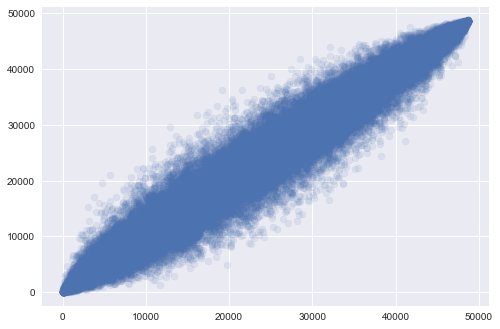

In [50]:
plt.scatter(a, b, alpha=.1)
plt.show()

In [62]:
data.shape

(307507, 2030)

In [63]:
datanull_vc = data.isnull().sum()

In [64]:
data.shape[0] * .75

230630.25

In [67]:
datanull_vc[datanull_vc > data.shape[0] * .75].shape

(440,)

In [59]:
pd.Series(lg_clf.clf.feature_importances_).value_counts()

0      445
1       99
2       64
3       43
4       34
11      31
12      28
7       28
18      27
14      27
19      26
16      26
22      26
10      26
25      24
20      24
17      24
9       24
6       24
15      23
21      23
5       22
13      22
24      20
23      19
27      18
28      18
50      18
30      16
8       16
      ... 
141      1
181      1
133      1
757      1
93       1
106      1
110      1
123      1
124      1
64       1
128      1
129      1
130      1
131      1
132      1
137      1
175      1
142      1
144      1
147      1
150      1
151      1
157      1
158      1
161      1
162      1
163      1
168      1
170      1
876      1
Length: 189, dtype: int64